In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 27.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
# from tensorflow.keras.utils.np_utils import to_categorical
%matplotlib inline

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/train.csv",index_col=False)
data_test = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/test.csv",index_col=False)

In [ ]:
data_train.sort_values(by='len',ascending=False).head(10)

,Class,Data,len,text
3963,0,Không phủ nhận các dòng card thế hệ mới đang h...,2885,Không phủ nhận các dòng card thế hệ ...
3660,0,Đánh giá Miband 1S có đo nhịp tim ở bài #2 bên...,2147,Đánh giá Miband 1S có đo nhịp tim ở bài...
3522,0,"​ Nhiều năm trước, Microsoft có một tầm nhìn k...",1544,​ Nhiều năm trước Microsoft có một ta...
3631,0,Mình Post lại bài Review nhỏ của mình về chiếc...,1420,Mình Post lại bài Review nhỏ của mình ve...
3804,0,Miband 2 đã về VN. Lúc này các bác thương gia ...,1157,Miband_2 đã về VN Lúc này các bác thưo...
2744,1,Nay hàng về đến tay mình trải nghiệm được nửa ...,631,Nay hàng về đến tay mình trải nghiệm ...
3463,0,"Nếu cảm thấy ổ cứng SSD dung lượng 1, 2 TB vẫn...",628,Nếu cảm thấy ổ cứng SD dung lượng_...
3639,0,Polar M600 được trang bị không phải một mà tới...,519,Polar M600 được trang bị không phải mộ...
3659,0,"Đánh giá Miband 2 ​Chào các bạn, như có thể th...",420,Đánh giá Miband_2 ​ Chào các bạn như có...
3938,0,Bạn xem lại pic test game Doom trên nèn Vulkan...,400,Bạn xem lại bic test game Dom trên nèn Vul...


<Axes: >

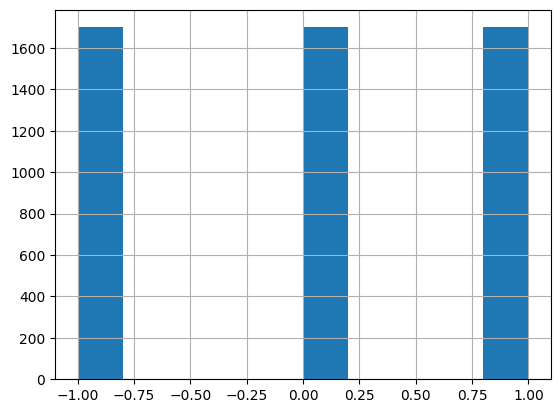

In [ ]:
data_train['Class'].hist()

In [ ]:
data_train[data_train['Class'] == 1]['text'].to_list()

In [ ]:
import nltk

# nltk.download('all')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

#use for LSTM and WordEmbedding Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from tensorflow.keras.layers import Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.initializers import Constant

**Metric**

In [ ]:
def calculate_metrics(X_test_scaled, Y_test,model = None):
    # Get model predictions
    if model:
       y_predict_r = model.predict(X_test_scaled)
    else:
       y_predict_r = X_test_scaled
    # Calculate evaluation metrics for assesing performance of the model.
    # roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r, average='macro')
    rec = recall_score(Y_test, y_predict_r, average='macro')
    f1 = f1_score(Y_test, y_predict_r, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model = None):
    # All features of dataset are float values. You normalize all features of the train and test dataset here.

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    # Make predictions on test dataset and calculate metrics.

    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model = model)

    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df

In [ ]:
X_train = data_train['text'].to_list()
X_test = data_test['text'].to_list()
y_train = data_train['Class'].to_list()
y_test = data_test['Class'].to_list()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.05,random_state=16)

In [ ]:
len(X_test)

1050

**Embedding**

In [ ]:
max_len = 650

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
def get_last_line(data):
    new_data = []
    for str_line in data:
        tokens = str_line.split(' ')
        tokens = tokens[-min(max_len,len(str_line)) : ]
        tokens = ' '.join(tokens)
        new_data.append(tokens)
    return new_data

In [ ]:
X_train_pad = tokenizer.texts_to_sequences(get_last_line(X_train))
X_train_pad=pad_sequences(X_train_pad,maxlen=max_len,padding='post')

X_test_pad = tokenizer.texts_to_sequences(get_last_line(X_test))
X_test_pad=pad_sequences(X_test_pad,maxlen=max_len,padding='post')

X_valid_pad = tokenizer.texts_to_sequences(get_last_line(X_val))
X_valid_pad=pad_sequences(X_valid_pad,maxlen=max_len,padding='post')

**TF-IDF**

In [ ]:
max_feature = 5000
vectorizer = TfidfVectorizer(max_features = max_feature, ngram_range = (2,2))

train_emb_TFIDF_ml = vectorizer.fit_transform(X_train).toarray()
valid_emb_TFIDF_ml = vectorizer.transform(X_val).toarray()
test_emb_TFIDF_ml = vectorizer.transform(X_test).toarray()

In [ ]:
len(train_emb_TFIDF_ml)

4845

**Phobert**

#Method

**Non parametric model**

In [ ]:
random_forestModel = RandomForestClassifier(n_estimators=500,
                                            max_depth=10,
                                            min_samples_split=400,
                                            random_state=12,
                                            max_features="auto")

scaler = StandardScaler().fit(train_emb_TFIDF_ml)
X_train_scaled = scaler.transform(train_emb_TFIDF_ml)

random_forestModel.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=10, max_features='auto', min_samples_split=400,
                       n_estimators=500, random_state=12)

In [ ]:
X_test_scaled = scaler.transform(test_emb_TFIDF_ml)

all_features_eval_df = get_metrics(X_test_scaled , y_test, random_forestModel)
all_features_eval_df.index = ['RandomForest']

results = pd.DataFrame({})
results = results.append(all_features_eval_df)
results.tail(10)

<ipython-input-21-81f359e3ba1c>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score
RandomForest,0.565714,0.581709,0.565714,0.564813


In [ ]:
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

In [ ]:
clf_xgboost = xgb.XGBClassifier()
clf_xgboost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
all_features_eval_df = get_metrics(X_test_scaled , y_test, clf_xgboost)
all_features_eval_df.index = ['XGboost']

results = results.append(all_features_eval_df)
results.tail(10)

<ipython-input-24-3e84d8cb14e4>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score
RandomForest,0.565714,0.581709,0.565714,0.564813
XGboost,0.571429,0.584342,0.571429,0.570524


**SVM**

In [ ]:
from sklearn import svm

model_svm = svm.SVC(C = 0.8, kernel = 'linear')
model_svm.fit(X_train_scaled, y_train)

SVC(C=0.8, kernel='linear')

In [ ]:
all_features_eval_df = get_metrics(X_test_scaled , y_test, model_svm)
all_features_eval_df.index = ['svm']
all_features_eval_df['Description'] = 'with TF-IDF 5000 feature'

results = results.append(all_features_eval_df)
results.tail(10)

<ipython-input-26-a7a863147402>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C = 1.0)
logreg.fit(X_train_scaled, y_train)
all_features_eval_df = get_metrics(X_test_scaled , y_test, logreg)
all_features_eval_df.index = ['logsitic_regression']
all_features_eval_df['Description'] = ''

results = results.append(all_features_eval_df)
results.tail(10)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-27-8715dd5dde8c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,


**Naive bayes**

In [ ]:
import numpy as np

def count_tweets(tweets, ys):
    result = {}
    for y,tweet in zip(ys,tweets):
        lst_tweet = tweet.strip().split()
        for word in lst_tweet:
            tup = (word,y)
            if tup in result.keys():
               result[tup] += 1
            else:
               result[tup] = 1
    return result

def train_naive_bayes(freqs,train_x,train_y):
    loglikelihood = {}
    logprior = 0

    N_pos = 0
    N_neg = 0

    vocab = set([ele[0] for ele in freqs.keys()])

    for pair in freqs.keys():
        if pair[1] == 1:
           N_pos += freqs[pair]
        else:
           N_neg += freqs[pair]

    D = len(train_y) #number of sentences
    D_pos = np.sum(train_y == np.ones(len(train_y)))
    D_neg = D - D_pos

    V = len(vocab)
    log_prior = np.log(D_pos) - np.log(D_neg)
    log_likelihood = {}
    for word in vocab:
        freqs_pos = freqs.get((word,1),0)
        neg_pos = freqs.get((word,0),0)

        #smoothing
        freqs_pos_prob = (freqs_pos + 1)/(N_pos + V)
        freqs_neg_prob = (neg_pos + 1)/(N_neg + V)

        log_likelihood[word] = np.log(freqs_pos_prob) - np.log(freqs_neg_prob)

    return log_prior,log_likelihood

def naive_bayes_predict(tweet,log_prior,log_likelihood):
    tweet = tweet.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]
    res += log_prior

    return res

def test_naive_bayes(test_x,test_y,log_prior,log_likelihood):
    y_hat = []
    for tweet in test_x:
        # print(tweet)
        res = naive_bayes_predict(tweet,log_prior,log_likelihood)
        if res >= 0.5:
           y_hat.append(2)
        elif res <= -0.5:
           y_hat.append(0)
        else:
          y_hat.append(1)

    y_hat = np.array(y_hat)
    accuracy = np.sum(test_y == y_hat)/len(y_hat)
    return accuracy, y_hat

def predict(sentence,log_likelihood,log_prior):
    tweet = sentence.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]

    res += log_prior
    if res >= 0:
       return "positive"
    return "negative"

In [ ]:
freqs = count_tweets(X_train,y_train)
log_prior,log_likelihood = train_naive_bayes(freqs,X_train,y_train)

train_res,_ = test_naive_bayes(X_train,y_train,log_prior,log_likelihood)
test_res,y_hat = test_naive_bayes(X_test,y_test,log_prior,log_likelihood)

print('train_acc: ',train_res)
print('test_acc: ',test_res)

train_acc:  0.34076367389060885
test_acc:  0.35619047619047617


In [ ]:
all_features_eval_df = get_metrics(y_hat, y_test, None)
all_features_eval_df.index = ['naive_bayes']

results = results.append(all_features_eval_df)
results.tail(10)

<ipython-input-30-7650d9de4a71>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,
naive_bayes,0.356190,0.413542,0.356190,0.243734,NaN


**Deep Learning method**

In [ ]:
def transform_y(labels):
    encoded_labels = []

    for label in labels:
        if label == 0:
            encoded_labels.append([1,0,0])
        elif label == 1:
            encoded_labels.append([0,1,0])
        else:
            encoded_labels.append([0,0,1])

    encoded_labels = np.array(encoded_labels)

    return encoded_labels

In [ ]:
import tensorflow

model_LSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_LSTM_tf_idf.compile(loss = 'categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model_LSTM_tf_idf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (Spatial  (None, 1, 5000)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 1, 128)            2626048   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

In [ ]:
train_emb_TFIDF_DL = np.expand_dims(train_emb_TFIDF_ml, axis = 1)
valid_emb_TFIDF_DL = np.expand_dims(valid_emb_TFIDF_ml, axis = 1)
test_emb_TFIDF_DL = np.expand_dims(test_emb_TFIDF_ml, axis = 1)

In [ ]:
y_train_DL = transform_y(y_train)
y_test_DL = transform_y(y_test)
y_val_DL = transform_y(y_val)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_LSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 [==============================] - 18s 43ms/step - loss: 1.0968 - accuracy: 0.3370 - val_loss: 1.1051 - val_accuracy: 0.3098
Epoch 2/50
76/76 [==============================] - 1s 19ms/step - loss: 0.9915 - accuracy: 0.5404 - val_loss: 1.4518 - val_accuracy: 0.1843
Epoch 3/50
76/76 [==============================] - 1s 18ms/step - loss: 0.7342 - accuracy: 0.6834 - val_loss: 1.7325 - val_accuracy: 0.2039
Epoch 4/50
76/76 [==============================] - 1s 18ms/step - loss: 0.6277 - accuracy: 0.7329 - val_loss: 1.9263 - val_accuracy: 0.2039
Epoch 5/50
76/76 [==============================] - 1s 18ms/step - loss: 0.5507 - accuracy: 0.7725 - val_loss: 2.1135 - val_accuracy: 0.2275
Epoch 6/50
76/76 [==============================] - 1s 19ms/step - loss: 0.5054 - accuracy: 0.7971 - val_loss: 2.1311 - val_accuracy: 0.2314
Epoch 7/50
76/76 [==============================] - 1s 19ms/step - loss: 0.4801 - accuracy: 0.8031 - val_loss: 2.2810 - val_accuracy: 0.2235
Epoch 8/50
7

In [ ]:
inference = model_LSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_LSTM']

results = results.append(all_features_eval_df)
results.tail(10)

33/33 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-36-a081f04e5f3f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,
naive_bayes,0.356190,0.413542,0.356190,0.243734,NaN
TF_IDF_LSTM,0.306667,0.333333,0.102222,0.156463,NaN


In [ ]:
model_BiLSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    Bidirectional(tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation = 'relu'),
    Dense(3, activation='sigmoid')
])

model_BiLSTM_tf_idf.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_BiLSTM_tf_idf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spati  (None, 1, 5000)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 1, 256)            5252096   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_BiLSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 [==============================] - 30s 71ms/step - loss: 1.0864 - accuracy: 0.4289 - val_loss: 1.1314 - val_accuracy: 0.2039
Epoch 2/50
76/76 [==============================] - 6s 82ms/step - loss: 0.8337 - accuracy: 0.6450 - val_loss: 1.6029 - val_accuracy: 0.1804
Epoch 3/50
76/76 [==============================] - 6s 79ms/step - loss: 0.5963 - accuracy: 0.7579 - val_loss: 1.9592 - val_accuracy: 0.2353
Epoch 4/50
76/76 [==============================] - 5s 63ms/step - loss: 0.4962 - accuracy: 0.7946 - val_loss: 2.2286 - val_accuracy: 0.2353
Epoch 5/50
76/76 [==============================] - 4s 48ms/step - loss: 0.4364 - accuracy: 0.8256 - val_loss: 2.4831 - val_accuracy: 0.2314
Epoch 6/50
76/76 [==============================] - 5s 60ms/step - loss: 0.3915 - accuracy: 0.8386 - val_loss: 2.7759 - val_accuracy: 0.2235
Epoch 7/50
76/76 [==============================] - 2s 30ms/step - loss: 0.3858 - accuracy: 0.8425 - val_loss: 2.6584 - val_accuracy: 0.2431
Epoch 8/50
7

In [ ]:
inference = model_BiLSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_BiLSTM']

results = results.append(all_features_eval_df)
results.tail(10)

33/33 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-40-6becb70fe607>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,
naive_bayes,0.356190,0.413542,0.356190,0.243734,NaN
TF_IDF_LSTM,0.306667,0.333333,0.102222,0.156463,NaN
TF_IDF_BiLSTM,0.294286,0.333333,0.098095,0.151582,NaN


In [ ]:
model_LSTM_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 500, input_length=max_len),
    SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation = 'relu'),
    Dense(3, activation='softmax')
])
# compile model
model_LSTM_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model_LSTM_emb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 650, 500)          3055000   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 650, 500)          0         
 alDropout1D)                                                    
                                                                 
 lstm_6 (LSTM)               (None, 64)                144640    
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3201819 (12.21 MB)
Trainable params: 3201819 (12.21 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_LSTM_emb.fit(X_train_pad, y_train_DL, batch_size=128, epochs=50,
                     callbacks=[callback],
                    validation_data=(X_valid_pad, y_val_DL))

Epoch 1/50
38/38 [==============================] - 170s 4s/step - loss: 1.1007 - accuracy: 0.3298 - val_loss: 1.1009 - val_accuracy: 0.3490
Epoch 2/50
38/38 [==============================] - 148s 4s/step - loss: 1.0998 - accuracy: 0.3238 - val_loss: 1.0988 - val_accuracy: 0.3490
Epoch 3/50
38/38 [==============================] - 129s 3s/step - loss: 1.0990 - accuracy: 0.3309 - val_loss: 1.0986 - val_accuracy: 0.3490
Epoch 4/50
38/38 [==============================] - 129s 3s/step - loss: 1.0990 - accuracy: 0.3294 - val_loss: 1.0994 - val_accuracy: 0.3490
Epoch 5/50
 4/38 [==>...........................] - ETA: 1:52 - loss: 1.0989 - accuracy: 0.3242

KeyboardInterrupt: ignored

In [ ]:
inference = model_LSTM_emb.predict(X_test_pad)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_LSTM_embLearn']

results = results.append(all_features_eval_df)
results.tail(10)

33/33 [==============================] - 7s 190ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-48-258759a5603f>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
RandomForest,0.565714,0.581709,0.565714,0.564813,NaN
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,
naive_bayes,0.356190,0.413542,0.356190,0.243734,NaN
TF_IDF_LSTM,0.306667,0.333333,0.102222,0.156463,NaN
TF_IDF_BiLSTM,0.294286,0.333333,0.098095,0.151582,NaN
TF_IDF_LSTM_embLearn,0.333333,0.111111,0.333333,0.166667,NaN


**CBOW**

In [ ]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/train.csv", index_col=False)
data_test = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/test.csv", index_col=False)

In [ ]:
def encode_label(labels):
  encoded_labels = []

  for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

  return np.array(encoded_labels)

encoded_labels = encode_label(data_train['Class'].values)
encoded_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [ ]:
word_reviews = data_train['text'].to_list()

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [ ]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/longdoc_sentimentAnalysis/Lab5-CNN+W2V_Sentiment_Analysis/vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("Vocabulary size:", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Vocabulary size: 6232


**CRNN**

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPooling1D(64, strides=1)(conv_0)
conv_1 = MaxPooling1D(64, strides=1)(conv_1)
conv_2 = MaxPooling1D(64, strides=1)(conv_2)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_1 = LSTM(256,return_sequences=True)(concat)
lstm_0 = LSTM(128, dropout=drop, recurrent_dropout=drop)(lstm_1)

# ############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes input and output
model = Model(inputs, output)

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 300, 400)             2492800   ['input_3[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 300, 400)             0         ['embedding_3[0][0]']         
                                                                                                  
 conv1d (Conv1D)             (None, 300, 100)             120100    ['reshape[0][0]']             
                                                                                              

In [ ]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 [==============================] - 36s 2s/step - loss: 1.0042 - accuracy: 0.5725 - val_loss: 2.4153 - val_accuracy: 0.0637
Epoch 2/10
16/16 [==============================] - 28s 2s/step - loss: 0.6655 - accuracy: 0.7603 - val_loss: 1.3411 - val_accuracy: 0.3951
Epoch 3/10
16/16 [==============================] - 28s 2s/step - loss: 0.5708 - accuracy: 0.8083 - val_loss: 2.9094 - val_accuracy: 0.1412
Epoch 4/10
16/16 [==============================] - 29s 2s/step - loss: 0.3930 - accuracy: 0.8809 - val_loss: 3.5603 - val_accuracy: 0.1216
Epoch 5/10
16/16 [==============================] - 29s 2s/step - loss: 0.2789 - accuracy: 0.9174 - val_loss: 3.5241 - val_accuracy: 0.1882
Epoch 6/10
16/16 [==============================] - 29s 2s/step - loss: 0.2077 - accuracy: 0.9456 - val_loss: 4.2945 - val_accuracy: 0.1549
Epoch 7/10
16/16 [==============================] - 29s 2s/step - loss: 0.1710 - accuracy: 0.9566 - val_loss: 4.3384 - val_accuracy: 0.1490
Epoch 8/10
16/16 [==

In [ ]:
sequences_test = tokenizer.texts_to_sequences(data_test['text'].to_list())
word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encode_label(data_test['Class'].values)

In [ ]:
inference = model.predict(word_reviews_test)

33/33 [==============================] - 4s 86ms/step


In [ ]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['LSTM']

results = results.append(all_features_eval_df)
results.tail(10)

<ipython-input-77-ef40dcba07a2>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,Precision,Recall,F1 Score,Description
XGboost,0.571429,0.584342,0.571429,0.570524,NaN
svm,0.487619,0.487089,0.487619,0.485965,with TF-IDF 5000 feature
logsitic_regression,0.506667,0.507328,0.506667,0.506800,
naive_bayes,0.356190,0.413542,0.356190,0.243734,NaN
TF_IDF_LSTM,0.306667,0.333333,0.102222,0.156463,NaN
TF_IDF_BiLSTM,0.294286,0.333333,0.098095,0.151582,NaN
TF_IDF_LSTM_embLearn,0.333333,0.111111,0.333333,0.166667,NaN
CRNN,0.558095,0.571241,0.558095,0.536349,NaN
CNN,0.601905,0.637462,0.601905,0.567582,NaN
LSTM,0.567619,0.582836,0.567619,0.545919,NaN


In [ ]:
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

KerasTensor(type_spec=TensorSpec(shape=(None, 297, 100), dtype=tf.float32, name=None), name='conv1d_10/Relu:0', description="created by layer 'conv1d_10'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 300, 400)             2492800   ['input_6[0][0]']             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 298, 100)             120100    ['embedding_3[3][0]']         
                                                                                                  
 conv1d_10 (Conv1D)          (None,

In [ ]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 [==============================] - 23s 289ms/step - loss: 7.0475 - accuracy: 0.4458 - val_loss: 6.1264 - val_accuracy: 0.3431
Epoch 2/10
16/16 [==============================] - 3s 212ms/step - loss: 5.1671 - accuracy: 0.5988 - val_loss: 6.3853 - val_accuracy: 0.0745
Epoch 3/10
16/16 [==============================] - 5s 304ms/step - loss: 4.1249 - accuracy: 0.7071 - val_loss: 6.1094 - val_accuracy: 0.0314
Epoch 4/10
16/16 [==============================] - 3s 161ms/step - loss: 3.3871 - accuracy: 0.7748 - val_loss: 5.0830 - val_accuracy: 0.0755
Epoch 5/10
16/16 [==============================] - 3s 165ms/step - loss: 2.8491 - accuracy: 0.8125 - val_loss: 4.4434 - val_accuracy: 0.0931
Epoch 6/10
16/16 [==============================] - 3s 163ms/step - loss: 2.3697 - accuracy: 0.8488 - val_loss: 4.2797 - val_accuracy: 0.0647
Epoch 7/10
16/16 [==============================] - 4s 221ms/step - loss: 1.9897 - accuracy: 0.8863 - val_loss: 4.0164 - val_accuracy: 0.0569
Epoch

**LSTM**

In [ ]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 400)          2492800   
                                                                 
 reshape_11 (Reshape)        (None, 300, 400)          0         
                                                                 
 lstm_12 (LSTM)              (None, 300, 1024)         5836800   
                                                                 
 lstm_13 (LSTM)              (None, 300, 512)          3147776   
                                                                 
 lstm_14 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0   